# Phase-resolved turbulent dissipation

In [1]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm
from scipy import optimize
from scipy.signal import detrend
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import matplotlib.ticker as tck
from roxsi_pyfuns.plotting import multiple_formatter
from datetime import datetime as DT
from cftime import date2num, num2date
# Interactive plots
%matplotlib widget 

from roxsi_pyfuns import coordinate_transforms as rpct
from roxsi_pyfuns import wave_spectra as rpws
from roxsi_pyfuns import zero_crossings as rpzc
from roxsi_pyfuns import stats as rps
from roxsi_pyfuns import turbulence as rpt
from roxsi_pyfuns import plotting as rppl

# Paths
# rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/'
rootdir = r'/home/malila/ROXSI/Asilomar2022/SmallScaleArray/'
vec_root = os.path.join(rootdir, 'Vectors', 'Level1')
figdir = os.path.join(vec_root, 'img')
bathydir = os.path.join(rootdir, 'Bathy')
fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy_updated_1m.nc')
dsbat = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))


## 20-min test case
Use C3 Vector as test case.

In [9]:
# Serial numbers and corresponding mooring IDs
mids = ['C2', 'C3', 'C4']
sers = ['17212', '17219', '17371']
fs = 16 # Sampling freq
# Define number of sub-segments per wave cycle (should be even)
ncyc = 8
# Minimum R^2 threshold for inertial subrange fits
r2_thresh = 0.9
# Sample period
# t0 = pd.Timestamp('2022-07-14 14:00:00')
t0 = pd.Timestamp('2022-07-13 07:00:00')
# t0 = pd.Timestamp('2022-07-19 06:00:00')
t1 = t0 + pd.Timedelta(hours=6)
spd = 60 * 60 * 24 # Seconds per day
# Define expected headings in PCA coordinates for C2 & C3
heading_exp = {'C2': -125, 'C3': -90, 'C4': None}

# Lists for hourly burst averages
wave_int_e = {'{}'.format(m): [] for m in mids} # Interpolated wave elevations
wave_int_u = {'{}'.format(m): [] for m in mids} # Interpolated wave u velocities
wave_int_v = {'{}'.format(m): [] for m in mids} # Interpolated wave v velocities
wave_int_w = {'{}'.format(m): [] for m in mids} # Interpolated wave w velocities
# Dissipation rates per wave-cycle subsegment
diss_subsegs = {'{}/{}'.format(n, ncyc): [] for n in range(1,ncyc+1)}
# diss_subseg = {'{}'.format(m): diss_subsegs for m in mids}
diss_subseg = {'{}'.format(m): {} for m in mids}
for mid in mids:
    diss_subseg[mid] = {'{}/{}'.format(n, ncyc): [] for n in range(1,ncyc+1)}
# Mean horizontal velocities U per wave-cycle subsegment
Us = {'q{}'.format(n): [] for n in range(1,ncyc+1)}
u_subseg =  {'{}'.format(m): Us for m in mids}

# Define number of bins to use for advection speed U (1-4)
nbins = 4
# Define type of fit to use for dissipation rate calculation
fit = 'linear'

# Test plot 1, k-spectra and -5/3 fits
plot1 = True
plot2 = False

# Iterate over C2, C3, C4 moorings
for mid, ser in zip(mids, sers):
    print('{} - {}'.format(mid, ser))
    # Read netcdf file, check if need to concatenate multiple days
    if ((t1.date() - t0.date()).total_seconds() / spd) > 0:
        # More than one day -> concatenate daily datasets
        drc = pd.date_range(t0.date(), t1.date(), freq='1D') # Range of dates
        dlc = [] # List for concatenating
        for d in drc:
            ncdir = os.path.join(vec_root, mid)
            fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(
                ser, str(d.strftime('%Y%m%d'))))
            dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
            # Append to list
            dlc.append(dsv)
        # Concatenate daily datasets
        dsv = xr.concat(dlc, dim='time')
    else:
        # Only one day
        ncdir = os.path.join(vec_root, mid)
        fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(ser, 
            str(t0.strftime('%Y%m%d'))))
        dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))

    # Wave couter
    wcnt = 0
    # Iterate over bursts
    time_range = pd.date_range(t0, t1, freq='1H')
    for t0b in time_range:
        t1b = t0b + pd.Timedelta(hours=1)
        if t1b > t1:
            continue
        # print('{}-{}'.format(t0b, t1b.time()))
        # Select sample period
        seg = dsv.sel(time=slice(t0b, t1b))
        eta = seg.eta_lin_krms.copy().to_series() # Surface elevation

        # Convert velocities to cross-/alongshore
        # x vel, despiked
        uxd = seg.uxd.to_dataframe() # Convert to pandas
        uxd = uxd.interpolate(method='bfill').interpolate('ffill')
        uxd -= uxd.mean()
        # y vel, despiked
        uyd = seg.uyd.to_dataframe() # Convert to pandas
        uyd = uyd.interpolate(method='bfill').interpolate('ffill')
        uyd -= uyd.mean()
        # z vel, despiked
        uzd = seg.uzd.to_dataframe() # Convert to pandas
        uzd = uzd.interpolate(method='bfill').interpolate('ffill')
        uzd -= uzd.mean()
        # Rotate velocities to cross/alongshore & vertical using PCA
        ucs, uls, uw = rpct.enu_to_loc_pca(ux=uxd.values.squeeze(), 
                                           uy=uyd.values.squeeze(), 
                                           uz=uzd.values.squeeze(),
                                           heading_exp=heading_exp[mid], 
                                           # print_msg=True,
                                           )

        # Estimate full w-spectrum (testing)
        wspec = rpws.spec_uvz(uw, fs=16)

        # Get zero-crossings, min. 4-sec waves
        zc, Hw, Hc, Ht = rpzc.get_waveheights(eta.values, method='up', minlen=4*16)
        nwaves = len(Hw)
        # Compute H(1/3)
        Hws = np.sort(Hw) # Sorted wave heights
        H13 = np.mean(Hws[2*(nwaves//3):]) # Mean of highest 1/3 of waves
        # Define phase (x) axis to interpolate to
        n_phase = 160 # Number of points in phase axis
        min_period = 6 # Min. wave period (sec) to include

        # Lists for storing dataframes of spectral segments for merging
        # for different ranges of advection speed U
        dfsi_lists_1 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
        dfsi_lists_2 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
        dfsi_lists_3 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
        dfsi_lists_4 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
        # Interpolate eta, u_cs and w for each wave to wave phase (0-2*pi)
        for zi,zc0 in enumerate(zc[:-1]):
            # Only include waves with T > min_period sec
            Tw = (eta.index[zc[zi+1]] - eta.index[zc[zi]]).total_seconds()
            if Tw < min_period:
                continue
            # Also only include high waves
            Hwi = Hw[zi]
#             if Hwi < H13:
#                 continue
            # Wave surface elevation, u, v and w for current wave
            eta_wave = eta.iloc[zc0:zc[zi+1]]
            u_wave = ucs[zc0:zc[zi+1]]
            v_wave = uls[zc0:zc[zi+1]]
            w_wave = uw[zc0:zc[zi+1]]
            # Surface elevation interpolation
            df_e = rpzc.interpolate_phase(eta_wave.squeeze(), N=n_phase, 
                                          label='eta_int_{:04d}'.format(wcnt))
            wave_int_e[mid].append(df_e)
            # Cross-shore vel. interpolation
            df_u = rpzc.interpolate_phase(u_wave.squeeze(), N=n_phase, 
                                          label='u_int_{:04d}'.format(wcnt))
            wave_int_u[mid].append(df_u)
            # Long-shore vel. interpolation
            df_v = rpzc.interpolate_phase(v_wave.squeeze(), N=n_phase, 
                                          label='u_int_{:04d}'.format(wcnt))
            wave_int_v[mid].append(df_v)
            # Vertical vel. interpolation
            df_w = rpzc.interpolate_phase(w_wave.squeeze(), N=n_phase, 
                                          label='u_int_{:04d}'.format(wcnt))
            wave_int_w[mid].append(df_w)
            # Increase wave counter
            wcnt =+ 1

            # Estimate spectra for 1/ncyc wave cycles
            nsub = n_phase // ncyc
            # Frequencies
            n_freqs = int(np.floor(nsub / 2 )) # No. of frequency bands
            # Wavenumbers to interpolate spectrum to
            n_int = n_freqs * 3 # Number of wavenumbers to interpolate to
            kmin = (2*np.pi) / 0.5 # Min. interpolation wavenumber
            kmax = (2*np.pi) / 0.05 # Max. interpolation wavenumber
            ki = np.linspace(kmin, kmax, n_int) # Interp. target k's
            # Initialize dict to store spectral dataframes for different ranges
            # of the advection velocity U
            dfsi = {}
            for nb in range(1, nbins+1):
                dfsi['{}'.format(nb)] = {}
            for i in range(ncyc):
                # Get short-segment velocities
                useg = df_u.iloc[i*nsub:(i+1)*nsub].values.squeeze()
                vseg = df_v.iloc[i*nsub:(i+1)*nsub].values.squeeze()
                wseg = df_w.iloc[i*nsub:(i+1)*nsub].values.squeeze()
                # Compute mean current and check that U >> dU for segment
                U = np.sqrt(np.mean(useg)**2 + np.mean(vseg)**2).item() # Mean orb. vel. mag.
                umag = np.sqrt(useg**2 + vseg**2) # Orb. vel. magnitude, not mean
                dU = np.std(umag) # Variability in umag (following George et al., 1994)
                # Check U/dU ratio
                if (U / dU) < 1:
                    # U vs. dU ratio (Eq (6) of George et al., 1994) too small
                    # Use U / dU = 1 as threshold following Rosman & Gerbi (2017), Fig. 9
                    continue
                # Estimate k-spectrum from wseg following George et al. (1994),
                # and append dataframe to dict. Save spectra for various
                # U bins based on requested number of U bins.
                if nbins == 1:
                    dfsi['1']['q{}'.format(i+1)] = rpt.k_spec_wavephase(
                        w=wseg, U=U, k_int=ki)
                elif nbins == 2:
                    if U < 0.50:
                        dfsi['1']['q{}'.format(i+1)] = rpt.k_spec_wavephase(
                            w=wseg, U=U, k_int=ki)
                    elif U >= 0.5: #and U < 0.75:
                        dfsi['2']['q{}'.format(i+1)] = rpt.k_spec_wavephase(
                            w=wseg, U=U, k_int=ki)
                elif nbins == 3:
                    if U < 0.25:
                        dfsi['1']['q{}'.format(i+1)] = rpt.k_spec_wavephase(
                            w=wseg, U=U, k_int=ki)
                    elif U >= 0.25 and U < 0.5:
                        dfsi['2']['q{}'.format(i+1)] = rpt.k_spec_wavephase(
                            w=wseg, U=U, k_int=ki)
                    elif U >= 0.5:
                        dfsi['3']['q{}'.format(i+1)] = rpt.k_spec_wavephase(
                            w=wseg, U=U, k_int=ki)
                elif nbins == 4:
                    if U < 0.15:
                        dfsi['1']['q{}'.format(i+1)] = rpt.k_spec_wavephase(
                            w=wseg, U=U, k_int=ki)
                    elif U >= 0.15 and U < 0.3:
                        dfsi['2']['q{}'.format(i+1)] = rpt.k_spec_wavephase(
                            w=wseg, U=U, k_int=ki)
                    elif U >= 0.3 and U < 0.45:
                        dfsi['3']['q{}'.format(i+1)] = rpt.k_spec_wavephase(
                            w=wseg, U=U, k_int=ki)
                    elif U >= 0.45:
                        dfsi['4']['q{}'.format(i+1)] = rpt.k_spec_wavephase(
                            w=wseg, U=U, k_int=ki)
                # Save U
                u_subseg[mid]['q{}'.format(i+1)].append(U)

            # Save dataframes to list for merging
            for n in range(1, ncyc+1):
                if 'q{}'.format(n) in dfsi['1'].keys():
                    dfsi_lists_1['dfs{}'.format(n)].append(
                        dfsi['1']['q{}'.format(n)])
                if nbins > 1:
                    if 'q{}'.format(n) in dfsi['2'].keys():
                        dfsi_lists_2['dfs{}'.format(n)].append(
                            dfsi['2']['q{}'.format(n)])
                if nbins > 2:
                    if 'q{}'.format(n) in dfsi['3'].keys():
                        dfsi_lists_3['dfs{}'.format(n)].append(
                            dfsi['3']['q{}'.format(n)])
                if nbins > 3:
                    if 'q{}'.format(n) in dfsi['4'].keys():
                        dfsi_lists_4['dfs{}'.format(n)].append(
                            dfsi['4']['q{}'.format(n)])

        # Concatenate spectral dataframes
        dfs = {}#, '2': {}, '3': {}}#, '4': {}}
        for nb in range(1, nbins+1):
            dfs['{}'.format(nb)] = {}
        for n in range(1, ncyc+1):
            if len(dfsi_lists_1['dfs{}'.format(n)]) > 0:
                dfs['1']['q{}'.format(n)] = pd.concat(
                    dfsi_lists_1['dfs{}'.format(n)], axis=1)
            if nbins > 1:
                if len(dfsi_lists_2['dfs{}'.format(n)]) > 0:
                    dfs['2']['q{}'.format(n)] = pd.concat(
                        dfsi_lists_2['dfs{}'.format(n)], axis=1)
            if nbins > 2:
                if len(dfsi_lists_3['dfs{}'.format(n)]) > 0:
                    dfs['3']['q{}'.format(n)] = pd.concat(
                        dfsi_lists_3['dfs{}'.format(n)], axis=1)
            if nbins > 3:
                if len(dfsi_lists_4['dfs{}'.format(n)]) > 0:
                    dfs['4']['q{}'.format(n)] = pd.concat(
                        dfsi_lists_4['dfs{}'.format(n)], axis=1)

        # Dicts to store curve fit coeff.
        rsqs = {} # R^2 value for best fit
        coeffs = {} # Fit coefficient for best fit
        sid = {} # Optimal start index for fit
        eid = {} # Optimal end index for fit
        diss_rate = {}
        # Define figure filename
        figdir_spec = os.path.join(figdir, 'turb_spec')
        if not os.path.isdir(figdir_spec):
            os.mkdir(figdir_spec)
        fn_fig = os.path.join(figdir_spec, 'kspec_{}_{}_ubins_{}_fit_{}.png'.format(
            mid, t0b.strftime('%Y%m%d_%H%M'), nbins, fit))
        # Initialize test plot 1, k-spectra and -5/3 fits
        if plot1 and not os.path.isfile(fn_fig):
            # Define fit function
            def fun(x, c):
                """
                Standard curve fit to inertial subrange k^{-5/3}.
                """
                return c * x ** (-5/3)
            nrows = ncyc//4
            fig, axes = plt.subplots(figsize=(7,2.5*nrows), 
                ncols=4, nrows=nrows, sharex=True, sharey=True)
            csu = ['C0', 'C1', 'C2', 'C3'] # Colors for plot
        # Iterate over sub-sections
        for n in range(1, ncyc+1):
            # Iterate over U ranges defined by nbins
            for ui in range(1, nbins+1):
                if not 'q{}'.format(n) in dfs[str(ui)].keys():
                    continue
                dfi = dfs[str(ui)]['q{}'.format(n)].copy()
                # Average spectra for wavenumbers with no more than maxnan % of
                # NaN values
                maxnan = 0.2 # Max. allowed % of NaNs per wavenumber
                ps_mean = dfi.where(
                    (dfi.isnull().sum(axis=1)/len(dfi.columns))<maxnan).mean(
                        axis=1).values
                # Lists to store curve fit coeff.
                rsqs_i = [] # R^2 value for best fit
                coeffs_i = [] # R^2 value for best fit
                sid_i = [] # Optimal start index for fit
                eid_i = [] # Optimal end index for fit
                npts = [] # Number of points to fit
                diss_i = [] # Dissipation rates
                # Iterate over different start/end freq. indices for fit
                # Disregard first (0-th) wavenumber
                sis = np.arange(1, n_int//2)
                eis = -np.arange(1, n_int//2)[::-1]
                for si in sis:
                    for ei in eis:
                        N = len(ki[si:ei])
                        # if N < 10 * 8//ncyc:
                        if N < n_int // 2:
                            # Don't try to fit to less than half of 
                            # available points
                            continue
                        # No NaNs allowed
                        if np.any(np.isnan(ps_mean[si:ei])):
                            continue
                        # Get diss. rate and R^2 of inertial subrange fit to 
                        # spectrum segment
                        epsilon, r_squared, coeff = rpt.dissipation_rate(
                            k=ki[si:ei], spec=ps_mean[si:ei], fit=fit)
                        # Save to dict if R^2 high enough
                        if r_squared >= r2_thresh:
                            rsqs_i.append(r_squared)
                            coeffs_i.append(coeff)
                            sid_i.append(si)
                            eid_i.append(ei)
                            npts.append(N)
                            diss_i.append(epsilon)
                # Find best fit from R^2 (highest) and fit length (longest)
                if len(rsqs_i) == 0:
                    # No fits were made (too many NaNs)
                    continue
                max_rsq_ind = np.argmax(rsqs_i)
                # Save parameters corresponding to max R^2
                rsqs['q{}'.format(n)] = rsqs_i[max_rsq_ind]
                coeffs['q{}'.format(n)] = coeffs_i[max_rsq_ind]
                sid['q{}'.format(n)] = sid_i[max_rsq_ind]
                eid['q{}'.format(n)] = eid_i[max_rsq_ind]
                diss_rate['q{}'.format(n)] = diss_i[max_rsq_ind]
                # Also append to ensemble-avg list
                diss_subseg[mid]['{}/{}'.format(n, ncyc)].append(
                    diss_i[max_rsq_ind])
                # Plot spectra and -5/3 fits for each wave-phase 
                # subsegment?
                if plot1 and not os.path.isfile(fn_fig):
                    # Check is current segment has data to plot
                    if 'q{}'.format(n) in sid.keys():
                        si = sid_i[max_rsq_ind]
                        ei = eid_i[max_rsq_ind]
                        rsq = rsqs_i[max_rsq_ind]
                        cf = coeffs_i[max_rsq_ind]
                        diss = diss_i[max_rsq_ind]
                        ax = axes.flat[n-1]
                        dfi.iloc[1:].mean(axis=1).plot(
                            ax=ax, c=csu[ui-1], label='ubin {}'.format(ui))
                        ax.loglog(ki[si:ei], fun(ki[si:ei], cf), 
                            linestyle='--', color='k')
                        if nbins == 1:
                            # Annotate R^2
                            ax.annotate(r'$R^2$='+'{:.2f}'.format(rsq), xy=(0.05, 0.03), 
                                        xycoords='axes fraction', fontsize=9)
                            # Annotate dissipation rate
                            ax.annotate(r'$\epsilon$='+'{:.2E}'.format(diss), 
                                        xy=(0.05, 0.11), xycoords='axes fraction', 
                                        fontsize=9)

        if plot1 and not os.path.isfile(fn_fig):
            # Labels & ticks
            for ax in axes[1,:]:
                ax.set_xlabel(r'$k$ [rad/m]')
                ax.set_xlim([10, 200])
                ax.set_ylim([1e-7, 1e-3])
                ax.set_xticks([10, 100])
                # ax.get_xaxis().get_major_formatter().labelOnlyBase = False
                ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
            for ax in axes[:,0]:
                ax.set_ylabel(r'$\phi(k)$ [$(\mathrm{m}^2\mathrm{s}^{-2})$/(rad/m)]')
            # Set log-log axes
            for na, ax in enumerate(axes.flat):
                if ax.lines:
                    # Legend if not empty plot (to avoid warnings)
                    ax.legend(fontsize=8)

                ax.set_xscale('log')
                ax.set_yscale('log')
                # Annotate sub segment number
                ax.annotate('{}/{}'.format(na+1, ncyc), xy=(0.03, 0.88), 
                            xycoords='axes fraction', fontsize=14)
            plt.suptitle('{} {}, # of U-bins: {}, fit: {}'.format(
                mid, t0b, nbins, fit))
            plt.tight_layout()
            # plt.show()
            plt.savefig(fn_fig, bbox_inches='tight', dpi=300)
            plt.close()

# Concatenate interpolated wave variables dataframes
df_ei = {'{}'.format(m): [] for m in mids}
df_ui = {'{}'.format(m): [] for m in mids}
df_vi = {'{}'.format(m): [] for m in mids}
df_wi = {'{}'.format(m): [] for m in mids}
print('Concatenating dataframes ...')
for mid in mids:
    df_ei[mid] = pd.concat(wave_int_e[mid], axis=1) # Interp. surface elevation
    df_ui[mid] = pd.concat(wave_int_u[mid], axis=1) # Interp. surface elevation
    df_vi[mid] = pd.concat(wave_int_v[mid], axis=1) # Interp. surface elevation
    df_wi[mid] = pd.concat(wave_int_w[mid], axis=1) # Interp. vertical vel.

# Average wave phase vs. dissipation rate plot
cs = ['k', 'b', 'r']
lss = ['-', '--', ':']
if plot2:
    fig, axes = plt.subplots(figsize=(5,6), nrows=3, sharex=True)
    for ax in axes:
        # Mark subsections
        for nc in np.arange(ncyc)[::2]:
            ax.axvspan(nc*2*np.pi/ncyc, (nc+1)*2*np.pi/ncyc, color='gray', 
                       alpha=0.25)
    # Iterate over moorings
    for m, mid in enumerate(mids):
        # Ensemble-avg eta on top, with +/- 1*std errorbars
        axes[0].errorbar(df_ei[mid].index, df_ei[mid].mean(axis=1), 
            ls=lss[m], yerr=df_ei[mid].std(axis=1), c=cs[m], capsize=3, 
            errorevery=((m+10),20), label=mid)
        # Ensemble-avg w in middle, with +/- 1*std errorbars
        axes[1].errorbar(df_wi[mid].index, df_wi[mid].mean(axis=1), 
            ls=lss[m], yerr=df_wi[mid].std(axis=1), c=cs[m], capsize=3, 
            errorevery=((m+10),20))
        # Dissipation rates per wave-phase subsection
        for n in range(1, ncyc+1):
            # All epsilon values for current phase subsection
            eps = diss_subseg[mid]['{}/{}'.format(n, ncyc)]
            # Centered x-locations
            positions = [n*2*np.pi/ncyc - np.pi/(ncyc) - (np.pi/16)*(2-(m+1))]
            # Box plot of epsilon range
            # axes[2].boxplot(x=eps, positions=positions, color=cs[m])
            rppl.box_plot(ax=axes[2], data=eps, positions=positions, 
                edge_color=cs[m], fill_color='white', showfliers=False)

    # Set x axis labels as multiples of pi
    for ax in axes:
        ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        # Grid
        ax.grid(alpha=0.5)

    # Axis labels
    axes[0].set_title('{}-{}'.format(t0, t1))
    axes[0].set_ylabel(r'$\langle \zeta \rangle$ [m]')
    axes[1].set_ylabel(r'$\langle w \rangle$ [m/s]')
    axes[2].set_ylabel(r'$\epsilon$ $[\mathrm{m}^2 \mathrm{s}^{-3}]$')

    axes[2].set_title('# of U-bins: {}'.format(nbins))

    # Legend on top row
    handles, labels = axes[0].get_legend_handles_labels()
    # remove the errorbars
    handles = [h[0] for h in handles]
    # use them in the legend
    axes[0].legend(handles, labels, loc='upper right')

    # Set dissipation rate y scale to log
    axes[2].set_yscale('log')
    axes[2].set_ylim([1e-6, 1e-2])

    plt.tight_layout()
    plt.show()
    # plt.close()


C2 - 17212
C3 - 17219
C4 - 17371
Concatenating dataframes ...


rsc: 0.9084673028453921, rsl: 0.9557987961719568


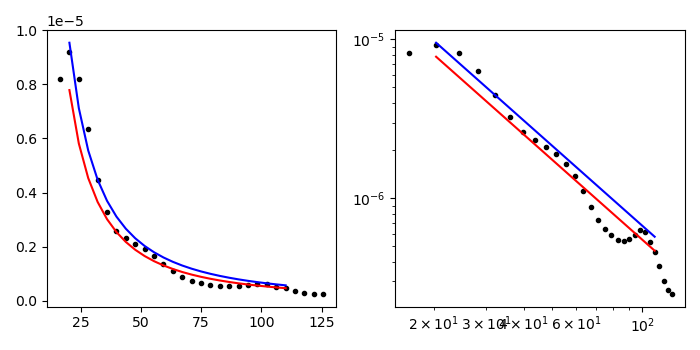

In [3]:
from scipy.optimize import curve_fit

k = dfi.iloc[1:].mean(axis=1).index
s = dfi.iloc[1:].mean(axis=1).values

def fun(x, c):
    """
    Standard curve fit to inertial subrange k^{-5/3}.
    """
    return c * x ** (-5/3)

si = 1
ei = -4
ec, rsc, cfc = rpt.dissipation_rate(k=k[si:ei], spec=s[si:ei], fit='curve')
el, rsl, cfl = rpt.dissipation_rate(k=k[si:ei], spec=s[si:ei], fit='linear')
print('rsc: {}, rsl: {}'.format(rsc, rsl))

fig, axes = plt.subplots(figsize=(7,3.5), ncols=2)
axes[0].plot(k, s, linestyle='none', marker='.', c='k')
axes[0].plot(k[si:ei], fun(k[si:ei], cfc), linestyle='-', color='b')
axes[0].plot(k[si:ei], fun(k[si:ei], cfl), linestyle='-', color='r')
axes[1].loglog(k, s, linestyle='none', marker='.', c='k')
axes[1].loglog(k[si:ei], fun(k[si:ei], cfc), linestyle='-', color='b')
axes[1].loglog(k[si:ei], fun(k[si:ei], cfl), linestyle='-', color='r')

plt.tight_layout()
plt.show()
# plt.close()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


r_sq: -0.74


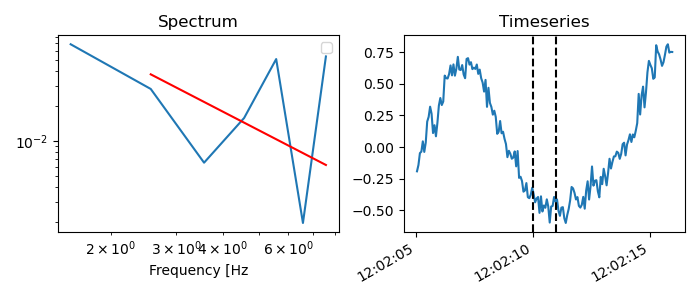

In [104]:
# Spectral segment start
t0s = t0 + pd.Timedelta(minutes=2, seconds=10)
dt = 1 # Spectral segment length, sec
seg = dsv.uU.sel(time=slice(t0s, t0s+pd.Timedelta(seconds=dt)))

# Spectrum estimation
fs = 16 # Sampling freq
# FFT of segment
fft_win = np.fft.fft(seg.values - np.mean(seg.values))
# Frequencies
n_freqs = int(np.floor(len(fft_win) / 2 )) # No. of frequency bands
# Calculate Nyquist frequency and bandwidth (freq. resolution)
nyquist = 0.5 * fs # Max spectral frequency
bandwidth = nyquist / n_freqs
# Find middle of each frequency band, only works when
# merging odd number of bands
f = 1/len(seg) + bandwidth/2 + bandwidth*np.arange(n_freqs)
ps_win = 2 * np.real(fft_win[:len(seg)//2] * np.conj(fft_win[:len(seg)//2]))

# Fit inertial subrange
def fun(x, c):
    return c * x ** (-5/3)

popt, pcov = optimize.curve_fit(fun, f[2:], ps_win[2:])
residuals = ps_win[2:]- fun(f[2:], *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ps_win[2:]-np.mean(ps_win[2:]))**2)
r_squared = 1 - (ss_res / ss_tot)
print('r_sq: {:.2f}'.format(r_squared))

# Plot
fig, axes = plt.subplots(figsize=(7,3), ncols=2)
# Plot spectrum
axes[0].loglog(f[1:], ps_win[1:])
# Plot -5/3 tail
# axes[0].loglog(f[2:], f[2:]**(-5/3)*10, color='k', linestyle='--', label=r'$f^{-5/3}$')
# Plot fit
axes[0].loglog(f[2:], fun(f[2:], popt[0]), 'r-')
axes[0].set_xlabel('Frequency [Hz')
axes[0].set_title('Spectrum')
axes[0].legend()
# Plot segment time series
dts = 5 # +/- dt for plot segment
pseg = dsv.uE.sel(time=slice(t0s-pd.Timedelta(seconds=dts), 
                             t0s+pd.Timedelta(seconds=dt)+pd.Timedelta(seconds=dts)))
pseg.plot(ax=axes[1])
# Mark segment period
axes[1].axvline(t0s, color='k', linestyle='--')
axes[1].axvline(t0s+pd.Timedelta(seconds=dt), color='k', linestyle='--')
axes[1].set_xlabel(None)
axes[1].set_ylabel(None)
axes[1].set_title('Timeseries')
plt.tight_layout()
plt.show()